In [ ]:
import os, shutil
from glob import glob
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tensorflow.keras.layers import concatenate, Input, Conv2D, Flatten, Dense, MaxPooling2D, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from google.colab import files

# ЗАГРУЗКА ДАННЫХ

Будем использовать набор данных атрибутов CelebFaces (CelebA) от Kaggle и Google Colab https://www.kaggle.com/jessicali9530/celeba-dataset

## Присоединяем kaggle
Набор данных можно загрузить непосредственно в вашу среду Google Colab с помощью [Kaggle API] (https://www.kaggle.com/docs/api)

In [ ]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

## Загружаем Kaggle.json, загруженный из вашей зарегистрированной учетной записи kaggle.

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dansamara","key":"01987a35596ea9134f737f2282bfe026"}'}

## Верифицируем Kaggle. Сохраняем датасет в папку '/content'

In [ ]:
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d jessicali9530/celeba-dataset

100% 1.33G/1.33G [01:09<00:00, 30.2MB/s]
100% 1.33G/1.33G [01:09<00:00, 20.5MB/s]


## Распаковка

In [ ]:
# Распаковываем в папку '/content/data'
from zipfile import ZipFile
with ZipFile('celeba-dataset.zip', 'r') as zipObj:
  zipObj.extractall('./data/')

# НАСТРОЙКА

In [ ]:
# Путь до папки изображений
IMAGES_SOURCE_FOLDER = '/content/data/img_align_celeba/img_align_celeba'  # Путь до исходных файлов
IMAGES_FOLDER = '/content/data/img_align_celeba/classes'  # Путь до файлоп, разложенных по классам
CSV_FILE = '/content/data/list_attr_celeba.csv'
IMG_HEIGHT = IMG_WIDTH = 128
IMG_CHANELS = 3
INPUT_DIM = (128, 128, 3) # Массив изображений
NUM_CLASSES = 2
BATCH_SIZE = 100
LATENT_DIM = 50 # Размерность скрытого вектора (z)

## Количество изображений

Количество изображений:202599
Размер изобрадения: (218, 178, 3)


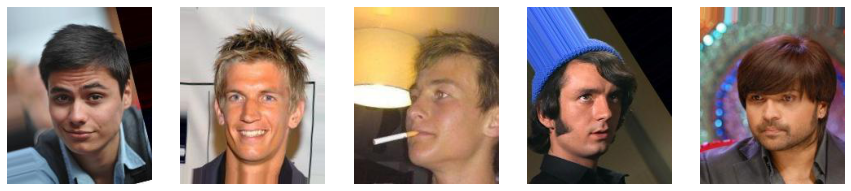

In [ ]:
# Модуль glob находит все пути, совпадающие с заданным шаблоном
file_names = np.array(glob(IMAGES_SOURCE_FOLDER + '/*.jpg'))
img_count = len(file_names)
print('Количество изображений:' + str(img_count))

fig = plt.figure(figsize=(15, 4))
for i in range(5):
  img = image.load_img(file_names[i])
  img_tensor = image.img_to_array(img)/255
  if (i == 0):
    print('Размер изобрадения:', img_tensor.shape)
  plt.subplot(1, 5, i+1)
  plt.imshow(img_tensor)
  plt.axis('off')
plt.show()

# ДАННЫЕ

### Датафрейм
Из всех колонок выбираем только 
* image_id
* Male

In [ ]:
df = pd.read_csv(CSV_FILE)
print('Датафрем:', df.head(10), '\n')

df_y = df[['image_id', 'Male']]

df_label = df[['Male']].copy()
df_label.loc[df['Male'] < 0, 'Male'] = 0

Датафрем:      image_id  5_o_Clock_Shadow  ...  Wearing_Necktie  Young
0  000001.jpg                -1  ...               -1      1
1  000002.jpg                -1  ...               -1      1
2  000003.jpg                -1  ...               -1      1
3  000004.jpg                -1  ...               -1      1
4  000005.jpg                -1  ...               -1      1
5  000006.jpg                -1  ...               -1      1
6  000007.jpg                 1  ...               -1      1
7  000008.jpg                 1  ...               -1      1
8  000009.jpg                -1  ...               -1      1
9  000010.jpg                -1  ...               -1      1

[10 rows x 41 columns] 



## Создадим наш генератор данных
Аргумент 'generator' должен быть вызываемым объектом, который возвращает объект, который поддерживает iter() протокол (например, генератор функция).
Элементы, сгенерированные с помощью 'generator' должны быть совместимы либо с заданным 'output_signature' аргументом, либо с заданными 'output_types' и (необязательно) 'output_shapes' аргументами, которые были указаны.

## tf.data.Dataset.from_generator
Хотел реальзовать собственный генератор для tf.dataset для модели с несколькими входными слоями, но не получилось. Это нужно для реальной работы с данными на несколько гигабайт. **Нужна помощь.**
В данный момент реализовал всё постаринке - все данные размещаются в оперативной памяти.

In [ ]:
'''
def my_generator():
  for i, row in df_y.iterrows():
    path_img = os.path.join(IMAGES_SOURCE_FOLDER, row['image_id'])
    pil_img = image.load_img(
        path = path_img, 
        color_mode='rgb', 
        target_size=(128, 128),
    )

    np_img = image.img_to_array(pil_img)

    df_label.loc[df['Male'] < 0, 'Male'] = 0
    label = df_label.to_numpy()
    label_cat = to_categorical(label[i], 2)

    x = [np_img, label_cat[0], label_cat[0]]
    y = label_cat[0]
    
    yield x, y, 

data_generator = tf.data.Dataset.from_generator(
    my_generator,
    output_types=((tf.float32, tf.float32, tf.float32), tf.float32),
    output_shapes=(((None, 128, 128, 3), (None, 2), (None, 2)), (None, 2))
)

data_generator = tf.data.Dataset.from_generator(
  my_generator,
  output_signature=(
    tf.TensorSpec(shape=None, dtype=tf.float32),
    tf.TensorSpec(shape=None, dtype=tf.float32),
  )
)
'''

In [ ]:
# print(data_generator.take(1))

## Традиционное решение создания датасета

In [ ]:
img_list = []
for i, row in df_y.iterrows():
  if i >= 10000:
    break

  path_img = os.path.join(IMAGES_SOURCE_FOLDER, row['image_id'])
  pil_img = image.load_img(
      path = path_img, 
      color_mode='rgb', 
      target_size=(128, 128),
  )

  np_img = image.img_to_array(pil_img)
  img_list.append(np_img)

x_train = np.array(img_list)/255
label = df_label.to_numpy()
y_train_cat = to_categorical(label[0:10000], 2)

print(x_train.shape)
print(y_train_cat.shape)

(10000, 128, 128, 3)
(10000, 2)


# ======= МОДЕЛЬ ============================

## Функции модели

In [ ]:
# Вектор распределения
def sampling(args):
  global z_mean, z_log_var
  z_mean, z_log_var = args
  N = K.random_normal(shape=(BATCH_SIZE, LATENT_DIM), mean=0., stddev=1.0)
  return z_mean + K.exp(z_log_var / 2)*N


# Функция ошибки для вариацинного автокодировщика (VAE)
# Между входным изображением и выходным
# vae_loss - функция ошибки для VAE
# вход:
#   original - истинные картинки (те, что поданы в качестве y)
#   decoded - картинки, созданные VAE
#   z_mean - мат.ожидание
#   z_log_var - дисперсия
# выход:
#   res - значение ошибки
def vae_loss(original, decoded):
  original = K.reshape(original, shape=(-1, IMG_HEIGHT*IMG_WIDTH*IMG_CHANELS))  # -1 = batch_size
  decoded = K.reshape(decoded, shape=(-1, IMG_HEIGHT*IMG_WIDTH*IMG_CHANELS))
  loss = K.sum(K.square(original - decoded), axis=-1)
  kl_loss = -0.5 * K.sum(1.0 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
  res = (loss + kl_loss)/2.0/IMG_HEIGHT/IMG_WIDTH/IMG_CHANELS
  return res

## Собираем модель

In [ ]:

# --- Энкодер ---
e_input = Input(shape=(INPUT_DIM), name='e_input')
e_flatten = Flatten(name='e_flatten')(e_input)
e_label = Input(shape=(NUM_CLASSES,), name='e_label')
e = concatenate([e_flatten, e_label], name='e_concatenate')
e = Dense(512, activation='relu', name='e_512')(e)
e = Dense(128, activation='relu', name='e_128')(e)

z_mean_layer = Dense(LATENT_DIM, name='z_mean_layer')(e)  # Математическое ожидание
z_log_var = Dense(LATENT_DIM, name='z_log_var')(e)  # Логарифм дисперсии

# Лямбда слой генерирует вектор случайной величины и умножается на дисперсию и прибавляем мат.ожидание
# и связываем с математическим ожиданием и огарифмом дисперсии
h = Lambda(sampling, output_shape=(LATENT_DIM,), name='Lambda')([z_mean_layer, z_log_var])  # shape=(100, 10)
print('h', h)

# --- Декодер ---
d_input = Input(shape=(LATENT_DIM,), name='d_input')
d_label = Input(shape=(NUM_CLASSES,), name='d_label')
d = concatenate([d_input, d_label], name='d_concatenate')
d = Dense(128, activation='relu', name='d_128')(d)
d = Dense(512, activation='relu', name='d_512')(d)
d = Dense(IMG_HEIGHT*IMG_WIDTH*IMG_CHANELS, activation='sigmoid', name='sigmoid')(d)
d = Reshape((IMG_HEIGHT, IMG_WIDTH, IMG_CHANELS), name='d_reshape')(d)

# --- Модели ---
encoder = Model([e_input, e_label], h, name='encoder')  # На вход передаём изображение и метку класса, на выходе - вектор h
decoder = Model([d_input, d_label], d, name='decoder')  # На вход - вектор скрытого состояния и метку класса, на выходе - изображение
cvae = Model([e_input, e_label, d_label], decoder([encoder([e_input, e_label]), d_label]), name="cvae")  # На входе - изображения, две метки - кодера и декодера
z_meaner = Model([e_input, e_label], z_mean_layer, name='z_meaner')
style = Model([e_input, e_label, d_label], decoder([z_meaner([e_input, e_label]), d_label]), name='style')

encoder.summary()
decoder.summary()
cvae.summary()


h KerasTensor(type_spec=TensorSpec(shape=(100, 50), dtype=tf.float32, name=None), name='Lambda/add:0', description="created by layer 'Lambda'")
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
e_input (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
e_flatten (Flatten)             (None, 49152)        0           e_input[0][0]                    
__________________________________________________________________________________________________
e_label (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
e_concatenate (Concatenate)     (None, 49154)  

In [ ]:
cvae.compile(loss=vae_loss, optimizer=Adam(0.00005))
cvae.fit([x_train, y_train_cat, y_train_cat], x_train, batch_size=BATCH_SIZE, epochs=1000, verbose=1)
# cvae.fit(data_generator, batch_size=BATCH_SIZE, epochs=10, verbose=1)

Epoch 1/1000
100/100 [==============================] - 9s 60ms/step - loss: 0.0464
Epoch 2/1000
100/100 [==============================] - 6s 59ms/step - loss: 0.0361
Epoch 3/1000
100/100 [==============================] - 6s 59ms/step - loss: 0.0290
Epoch 4/1000
100/100 [==============================] - 6s 59ms/step - loss: 0.0271
Epoch 5/1000
100/100 [==============================] - 6s 60ms/step - loss: 0.0256
Epoch 6/1000
100/100 [==============================] - 6s 58ms/step - loss: 0.0235
Epoch 7/1000
100/100 [==============================] - 6s 60ms/step - loss: 0.0223
Epoch 8/1000
100/100 [==============================] - 6s 59ms/step - loss: 0.0207
Epoch 9/1000
100/100 [==============================] - 6s 59ms/step - loss: 0.0194
Epoch 10/1000
100/100 [==============================] - 6s 59ms/step - loss: 0.0187
Epoch 11/1000
100/100 [==============================] - 6s 60ms/step - loss: 0.0180
Epoch 12/1000
100/100 [==============================] - 6s 60ms/step - lo

# РЕЗУЛЬТАТ

In [ ]:
# 0 - женщины, 1 - мужчины
def plot_faces(male=0):
  plt.figure(figsize=(20, 20))
  for i in range(20):
    mean = random.uniform(-1, 1)  # Мат.ожидание
    stddev = random.uniform(0.1, 2)  # Дисперсия
    random_vector = tf.random.normal(shape=[1, LATENT_DIM], mean=mean, stddev=1.0)
    input_lbl = np.zeros((1, 2))
    input_lbl[0, male] = 1
    plt.subplot(5, 5, i+1) # Выведем область рисования Axes
    plt.xticks([])  # Убираем ось х
    plt.yticks([])  # Убираем ось y
    plt.grid(False)  # Убираем стеку
    img = decoder.predict([random_vector, input_lbl])
    plt.imshow(img.squeeze()) 
    plt.xlabel(i, fontsize=14)

Женщины


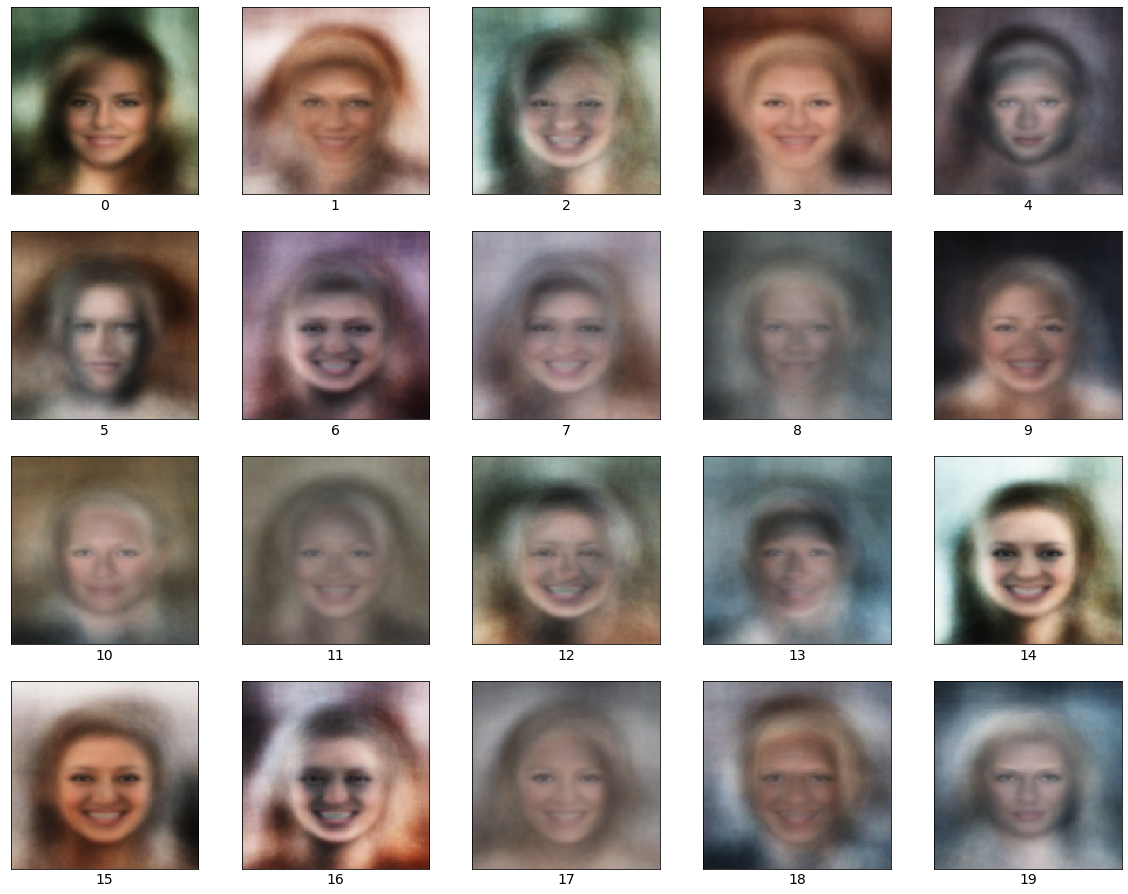

In [ ]:
print('Женщины')
plot_faces(0)

Мужчины


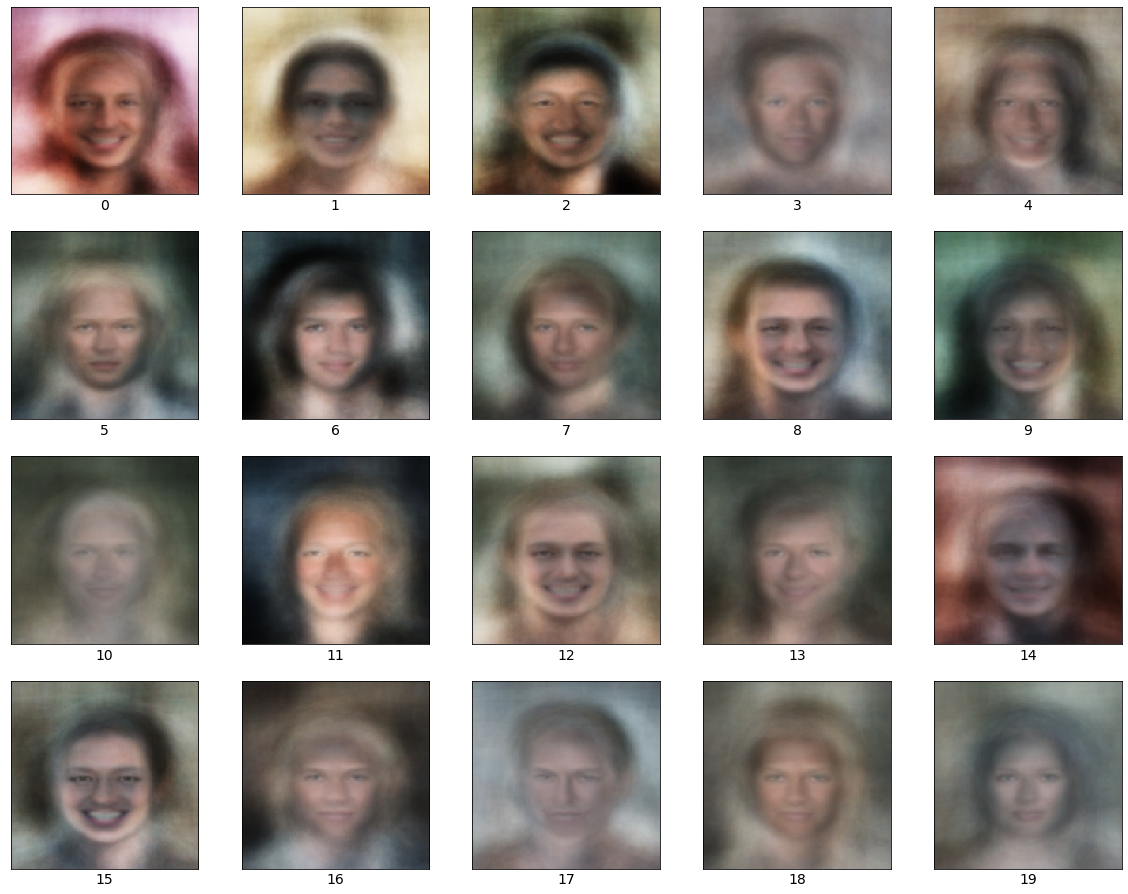

In [ ]:
print('Мужчины')
plot_faces(1)